# Test flask server

In [510]:
from isegm.inference import utils
from isegm.utils import vis, exp
import random

# selct a random image from dataset
DATASET = 'Berkeley' # Possible choices: 'GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal', 'SBD'
cfg = exp.load_config_file('./config.yml', return_edict=True)
dataset = utils.get_dataset(DATASET, cfg)
index = random.sample(range(len(dataset)), 1)[0]
sample = dataset.get_sample(index)
image_name = dataset.dataset_samples[index]
image_path = str(dataset._images_path / image_name)
mask_path = str(dataset._masks_paths[image_name.split('.')[0]])
gt_mask = sample.gt_mask


Error: connect ECONNREFUSED 127.0.0.1:58644

In [507]:
# generate click and send request
# run this block will reset click history
import requests
from isegm.inference.clicker import Clicker, Click
import numpy as np

# init mouse click
clicker = Clicker(gt_mask=gt_mask)
pred_mask = np.zeros_like(gt_mask)
ious_list = []
polygons = []
view_img = None

# Send request and display result
👉🏻 Execute this block multiple times to see iterative prediction results

Click(0): x:251, y:273, p:1
算法推理时间：0.39s
Iou: 98.0%
图片下载时间: 0.09s


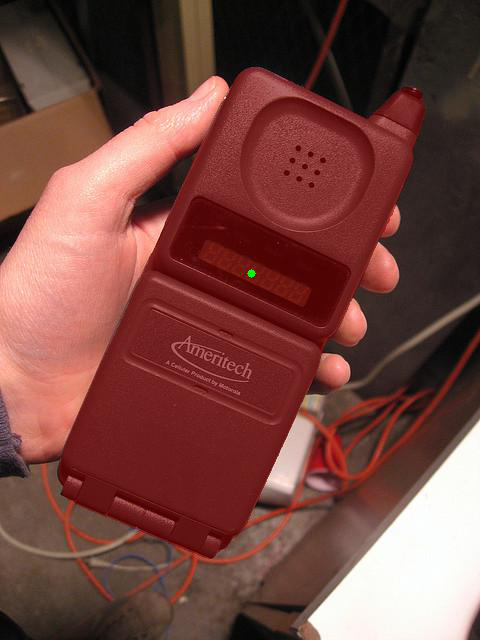

In [505]:
from imantics import Polygons, Mask, Annotation
import json, time
from PIL import Image
from io import BytesIO
IP = 'ec2-52-82-41-85.cn-northwest-1.compute.amazonaws.com.cn'
SEG_URL = f'http://{IP}:5005/interactive_segmentation'
IMG_URL = f'http://{IP}:5005/view_image/'

# gen clicks
clicker.make_next_click(pred_mask)
click_history = []
for click in clicker.clicks_list:
    (y, x, i) = click.coords_and_indx
    p = click.is_positive
    x , y, p = int(x), int(y), int(p)
    click_history.append({'x':x, 'y':y, 'positive':p, 'index': i})
print(f'Click({i}): x:{x}, y:{y}, p:{p}')
assert click_history[-1]['index'] == len(clicker.clicks_list)-1, f'Last history is not the current click'

# gen request
result = requests.post(SEG_URL, 
    data={
        # 'image': open(image_path, 'rb'),
        'click_history': json.dumps(click_history),
        'prev_polygon': json.dumps(polygons),
        'view_img': 'true'
    }, 
    files={
        'image': (image_name, open(image_path, 'rb')),
        'gt_mask': ('gt_mask', open(mask_path, 'rb')) 
    }
)
print(f'算法推理时间：{result.elapsed.total_seconds():.2f}s')

if result.status_code != 200:
    print(result)
else:
    print(f"Iou: {result.json()['iou']*100:.1f}%")
    #update prediction
    polygons = result.json()['polygons']
    img = Image.open(image_path)
    pred_mask = Polygons(polygons).mask(width=img.width, height=img.height).array

    #display image
    filename = result.json()['result']
    start = time.time()
    pred_img = requests.get(IMG_URL+filename)
    # print(f'图片下载时间：{pred_img.elapsed.total_seconds()}s')
    view_img = Image.open(BytesIO(pred_img.content))
    request_time = time.time() - start
    print(f"图片下载时间: {request_time:.2f}s")
view_img

In [500]:
result.json()['iou']

0.9585379236602558